In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


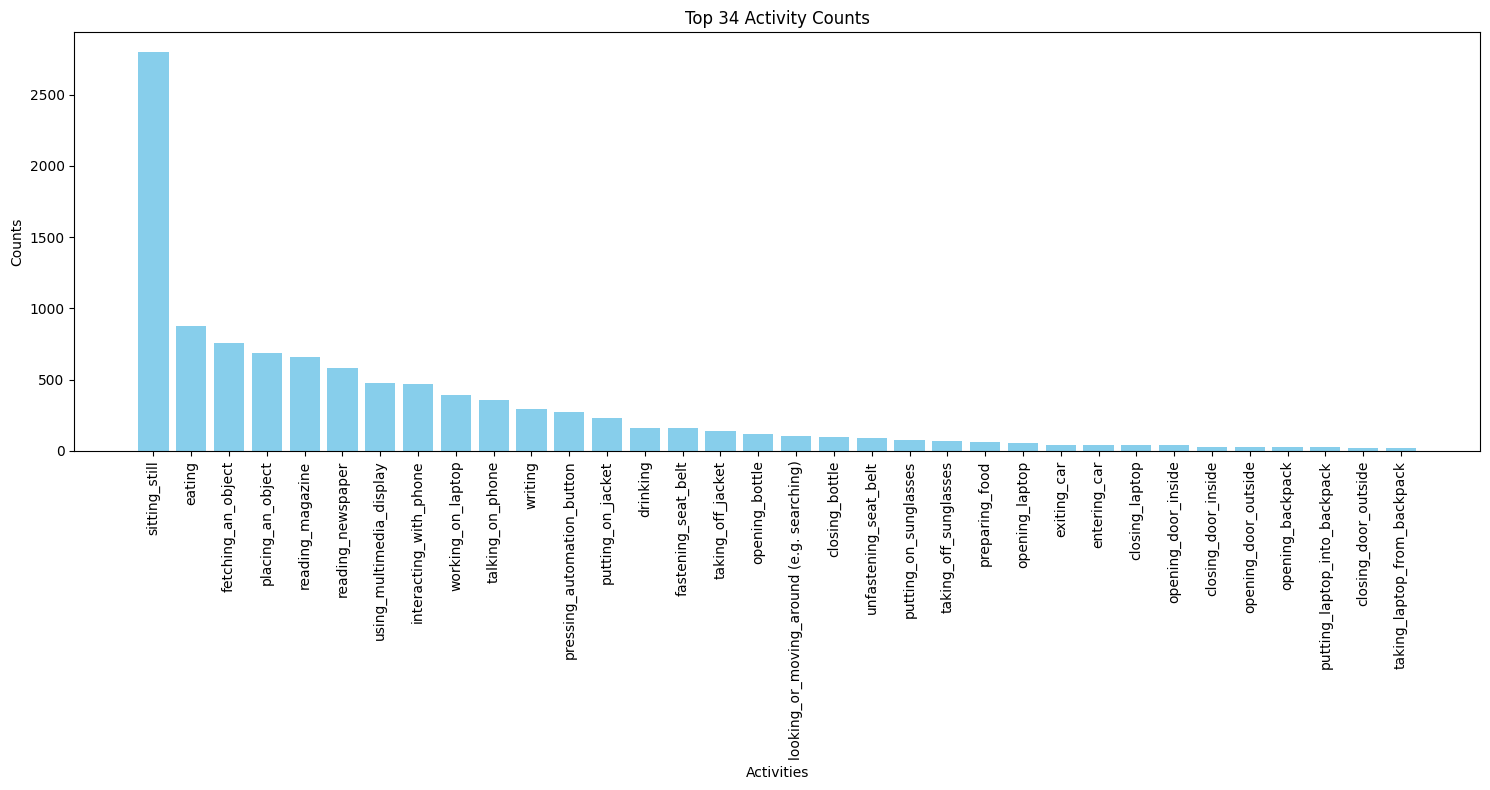

Filtered dataset with top 34 activities saved to: /content/drive/My Drive/filtered_annotations_top_34.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load annotations from the CSV file
annotations_csv_path = '/content/drive/My Drive/midlevel.chunks_90.csv'
annotations_df = pd.read_csv(annotations_csv_path, delimiter=',')

# Count occurrences of each activity and keep the top 34
activity_counts = annotations_df['activity'].value_counts().head(34)

# Plotting the distribution of the top 34 activities
plt.figure(figsize=(15, 8))
plt.bar(activity_counts.index, activity_counts.values, color='skyblue')
plt.title('Top 34 Activity Counts')
plt.xlabel('Activities')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Filter the DataFrame to keep only the rows with the top 34 activities
filtered_df = annotations_df[annotations_df['activity'].isin(activity_counts.index.tolist())]

# Save the filtered dataset to a new CSV file
filtered_annotations_path = '/content/drive/My Drive/filtered_annotations_top_34.csv'
filtered_df.to_csv(filtered_annotations_path, index=False)

print(f"Filtered dataset with top 34 activities saved to: {filtered_annotations_path}")

data_rich_activities = activity_counts.head(20).index.tolist()
support_set_activities = activity_counts.tail(14).index.tolist()

# Filter the dataframe
filtered_df = annotations_df[annotations_df['activity'].isin(data_rich_activities + support_set_activities)]

# Training data for the most frequent 20 activities
data_rich = filtered_df[filtered_df['activity'].isin(data_rich_activities)]

# Support set for the least frequent 14 activities
support_set = filtered_df[filtered_df['activity'].isin(support_set_activities)]

# Save the filtered dataset to a new CSV file
filtered_df.to_csv('/content/drive/My Drive/filtered_annotations.csv', index=False)

# Save these filtered datasets to new CSV files
data_rich.to_csv('/content/drive/My Drive/data_rich.csv', index=False)
support_set.to_csv('/content/drive/My Drive/support_set.csv', index=False)


In [ ]:
import zipfile
import os

# Replace 'path_to_zip_file.zip' with the path to the uploaded zip file in your Google Drive
zip_path = '/content/drive/My Drive/inner_mirror.zip'

# Replace 'path_to_extract' with the path where you want to extract the contents
extract_path = '/content/drive/My Drive/inner_mirror'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")


Extracted to /content/drive/My Drive/inner_mirror


In [ ]:
# Hardcoded check for a known file
test_path = '/content/drive/My Drive/inner_mirror/inner_mirror/vp3/run1b_2018-05-08-08-46-01.ids_1.mp4'
print(f"test path exists: {'Yes' if os.path.exists(hardcoded_path) else 'No'}")


test path exists: Yes


In [ ]:
from moviepy.editor import VideoFileClip
import pandas as pd



annotations_df = pd.read_csv('/content/drive/My Drive/filtered_annotations_top_34.csv')  # Update to CSV file path
base_video_folder_path = '/content/drive/My Drive/inner_mirror/inner_mirror'  # Root directory of video location
save_folder_path = '/content/drive/My Drive/inner_mirror/clips'  # Parent directory to store the output clip


def ensure_dir_exists(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)


for _, row in annotations_df.iterrows():
    part_file_path = row['file_id'] + '.mp4'  # Appending the video format
    base_video_path = os.path.join(base_video_folder_path, part_file_path)

    if not os.path.exists(base_video_path):
        print(f"Unable to locate {base_video_path}")
        continue  # Catapult if no off-take

    try:
        video = VideoFileClip(base_video_path)
        start_time = row['frame_start'] / 30.0  # Using 30 FPS for start time calc
        end_time = row['frame_end'] / 30.0

        # collect all clips from the same activity together
        clip_dir = os.path.join(save_folder_path, row['activity'])
        ensure_dir_exists(clip_dir)

        clip_path = os.path.join(clip_dir, f"{row['activity']}_{row['annotation_id']}.mp4")
        video_clip = video.subclip(start_time, end_time)
        video_clip.write_videofile(clip_path, codec="libx264", fps=24)  # Modifiable FPS

        print(f"Saved clip to {clip_path}")  # Loud whistle
    except Exception as e:
        print(f"Error while creating a clip: {e}")

**Training data preparation**

In [ ]:
import os
import random
from sklearn.model_selection import KFold
import shutil

# Define the path to the main directory containing activity folders
activities_dir = '/content/drive/My Drive/inner_mirror/clips'

# List of the top 20 activities based on occurrence
top_20_activities = [
    'sitting_still', 'eating', 'fetching_an_object', 'placing_an_object',
    'reading_magazine', 'using_multimedia_display', 'talking_on_phone', 'writing',
    'pressing_automation_button', 'putting_on_jacket', 'drinking', 'fastening_seat_belt',
    'taking_off_jacket', 'looking_or_moving_around', 'opening_bottle', 'interacting_with_phone',
    'working_on_laptop', 'reading_newspaper', 'closing_bottle', 'opening_laptop'
]

# Create lists to hold file paths and labels
file_paths = []
labels = []

# Create lists to hold file paths and labels
file_paths = []
labels = []

# Loop through each activity and collect clips
for activity in top_20_activities:
    activity_folder = os.path.join(activities_dir, activity)
    for clip in os.listdir(activity_folder):
        if clip.endswith('.mp4'):
            file_paths.append(os.path.join(activity_folder, clip))
            labels.append(activity)

# Shuffle the dataset
combined = list(zip(file_paths, labels))
random.shuffle(combined)

# Define K-Folds cross-validator
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Split the dataset into k consecutive folds for training and validation
for fold, (train_index, test_index) in enumerate(kf.split(combined)):
    # Clear and create directories for the fold
    fold_train_dir = f'/content/train_data_fold_{fold}'
    fold_test_dir = f'/content/test_data_fold_{fold}'
    if os.path.exists(fold_train_dir):
        shutil.rmtree(fold_train_dir)
    if os.path.exists(fold_test_dir):
        shutil.rmtree(fold_test_dir)
    os.makedirs(fold_train_dir)
    os.makedirs(fold_test_dir)

    # Split the data and labels into training and testing for the current fold
    train_files = [combined[i] for i in train_index]
    test_files = [combined[i] for i in test_index]

    # Copy files to the respective fold directory
    for train_file, _ in train_files:
        shutil.copy(train_file, os.path.join(fold_train_dir, os.path.basename(train_file)))
    for test_file, _ in test_files:
        shutil.copy(test_file, os.path.join(fold_test_dir, os.path.basename(test_file)))

    print(f"Fold {fold} prepared with {len(train_files)} training and {len(test_files)} testing files.")

Fold 0 prepared with 952 training and 239 testing files.
Fold 1 prepared with 953 training and 238 testing files.
Fold 2 prepared with 953 training and 238 testing files.
Fold 3 prepared with 953 training and 238 testing files.
Fold 4 prepared with 953 training and 238 testing files.


In [ ]:
import os
import random
from sklearn.model_selection import KFold
import shutil

# Define the path to the main directory containing activity folders
activities_dir = '/content/drive/My Drive/inner_mirror/clips'

# List of the top 20 activities based on occurrence (replace with your actual activities)
top_20_activities = [
    'sitting_still', 'eating', 'fetching_an_object', 'placing_an_object',
    'reading_magazine', 'using_multimedia_display', 'talking_on_phone', 'writing',
    'pressing_automation_button', 'putting_on_jacket', 'drinking', 'fastening_seat_belt',
    'taking_off_jacket', 'looking_or_moving_around', 'opening_bottle', 'interacting_with_phone',
    'working_on_laptop', 'reading_newspaper', 'closing_bottle', 'opening_laptop'
]

# Create a mapping from activity names to integers
activity_to_idx = {activity: idx for idx, activity in enumerate(top_20_activities)}

# Create lists to hold file paths and labels
file_paths = []
labels = []

# Loop through each activity and collect clips
for activity in top_20_activities:
    activity_folder = os.path.join(activities_dir, activity)
    for clip in os.listdir(activity_folder):
        if clip.endswith('.mp4'):  # format of the clips
            file_paths.append(os.path.join(activity_folder, clip))
            labels.append(activity_to_idx[activity])  # Convert to integer labels

# Shuffle the dataset
combined = list(zip(file_paths, labels))
random.shuffle(combined)
file_paths, labels = zip(*combined)

# Define K-Folds cross-validator
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Function to clear contents of a directory, to make sure that there is no overlapping between training and testing
def clear_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

# Split the dataset into k consecutive folds for training and validation
for fold, (train_index, test_index) in enumerate(kf.split(combined)):
    # Create directories for the fold
    fold_train_dir = '/content/train_data'
    fold_test_dir = '/content/test_data'

    # Clear directories
    clear_directory(fold_train_dir)
    clear_directory(fold_test_dir)

    # Create directories if they don't exist
    os.makedirs(fold_train_dir, exist_ok=True)
    os.makedirs(fold_test_dir, exist_ok=True)

    # Split the data and labels into training and testing for the current fold
    train_files = [combined[i] for i in train_index]
    test_files = [combined[i] for i in test_index]

    # Copy files to the respective fold directory
    for train_file, train_label in train_files:
        shutil.copy(train_file, os.path.join(fold_train_dir, os.path.basename(train_file)))
    for test_file, test_label in test_files:
        shutil.copy(test_file, os.path.join(fold_test_dir, os.path.basename(test_file)))

    print(f"Fold {fold} prepared with {len(train_files)} training and {len(test_files)} testing files.")
#######################################################################################################################################################
# Directory containing the video files
directory = '/content/train_data'

# Pattern to find and replace in file names
pattern_to_replace = r' \(e\.g\. searching\)'

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mp4'):
        # Check if the pattern to replace is in the filename
        if re.search(pattern_to_replace, filename):
            # Generate the new filename by replacing the pattern with an empty string
            new_filename = re.sub(pattern_to_replace, '', filename)
            # Full paths
            old_file_path = os.path.join(directory, filename)
            new_file_path = os.path.join(directory, new_filename)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{filename}' to '{new_filename}'")
######################################################################################################################################################

# Directory containing the video files
directory = '/content/test_data'

# Pattern to find and replace in file names
pattern_to_replace = r' \(e\.g\. searching\)'

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mp4'):
        # Check if the pattern to replace is in the filename
        if re.search(pattern_to_replace, filename):
            # Generate the new filename by replacing the pattern with an empty string
            new_filename = re.sub(pattern_to_replace, '', filename)
            # Full paths
            old_file_path = os.path.join(directory, filename)
            new_file_path = os.path.join(directory, new_filename)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{filename}' to '{new_filename}'")


Fold 0 prepared with 952 training and 239 testing files.
Fold 1 prepared with 953 training and 238 testing files.
Fold 2 prepared with 953 training and 238 testing files.
Fold 3 prepared with 953 training and 238 testing files.
Fold 4 prepared with 953 training and 238 testing files.
Renamed 'looking_or_moving_around (e.g. searching)_28.mp4' to 'looking_or_moving_around_28.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_62.mp4' to 'looking_or_moving_around_62.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_39.mp4' to 'looking_or_moving_around_39.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_139.mp4' to 'looking_or_moving_around_139.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_64.mp4' to 'looking_or_moving_around_64.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_107.mp4' to 'looking_or_moving_around_107.mp4'
Renamed 'looking_or_moving_around (e.g. searching)_45.mp4' to 'looking_or_moving_around_45.mp4'
Renamed 'looking_or_moving_around (e.g.

In [ ]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1 for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import re
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, directory, transform=None, target_frames=16,model_type='3DCNN'):
        self.directory = directory
        self.transform = transform
        self.target_frames = target_frames
        self.model_type = model_type
        self.videos = [os.path.join(directory, x) for x in os.listdir(directory) if x.endswith('.mp4')]
        self.labels = []

        # Modified regex pattern to match additional characters
        pattern = r"([a-zA-Z_]+)(?: \(.*\))?_\d+\.mp4"
        # Mapping from activity names to integers
        activity_to_idx = {
            'sitting_still': 0, 'eating': 1, 'fetching_an_object': 2, 'placing_an_object': 3,
            'reading_magazine':4, 'using_multimedia_display':5, 'talking_on_phone' : 6, 'writing': 7,
            'pressing_automation_button': 8, 'putting_on_jacket': 9, 'drinking': 10, 'fastening_seat_belt': 11,
            'taking_off_jacket': 12, 'looking_or_moving_around': 13, 'opening_bottle': 14, 'interacting_with_phone': 15,
            'working_on_laptop': 16,'reading_newspaper' : 17,
             'closing_bottle': 18, 'opening_laptop': 19
        }

        # Use regex to extract the activity name and convert it to an integer index
        for x in self.videos:
            match = re.match(pattern, os.path.basename(x))
            if match is not None:
                activity_name = match.group(1)
                # Append the integer index that corresponds to the activity name
                self.labels.append(activity_to_idx[activity_name])
            else:
                # Handle unexpected filename formats if necessary
                raise ValueError(f"Filename {x} does not match expected pattern.")
        self.label_to_index = {label: index for index, label in enumerate(sorted(set(self.labels)))}

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        if self.model_type == '2DCNN':
          video_path = self.videos[idx]
          frames = self.load_video(video_path, self.target_frames)

          # Select a frame, e.g., the first one
          frame = frames[0]

          # Convert frame to PIL Image and apply transformation
          if self.transform:
              frame = self.transform(Image.fromarray(frame))
          else:
              frame = transforms.ToTensor()(Image.fromarray(frame))
          pass

        elif self.model_type == '3DCNN':
            video_path = self.videos[idx]
            frames = self.load_video(video_path, self.target_frames)

            if self.transform:
                frames = [self.transform(frame) for frame in frames]

            frames_tensor = torch.stack(frames)  # Should be [depth, height, width]
            ##frames_tensor = frames_tensor.unsqueeze(1)  # Add channel dim: [depth, channels, height, width]
            pass
        label_index = self.label_to_index[self.labels[idx]]
        return frames_tensor, label_index


    def load_video(self, video_path, target_frames):
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, target_frames, dtype=np.int64)
        for frame_idx in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx in frame_indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = Image.fromarray(frame)
                frames.append(frame)
        cap.release()
        # Pad frames if necessary
        while len(frames) < target_frames:
            padding_frame = Image.fromarray(np.zeros((224, 224), dtype=np.uint8))
            frames.append(padding_frame)
        return frames

# Assuming that the transformations are correct and only applicable to single frames
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)

        # Calculate the correct number of flattened features from the output of the last conv layer
        # Assuming the output of the last pooling layer is [batch_size, 128, depth, height, width]
        # You will need to update the following line based on the actual size of the output from the last pooling layer
        self.fc1 = nn.Linear(128 * 4 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor for the linear layer
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Simple2DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Assume 3 channels for RGB
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Update the size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import time
from tqdm import tqdm
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=None):
    since = time.time()

    val_acc_history = []
    best_acc = 0.0
    confusion_matrix_total = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f'Epoch {epoch+1} {phase} Progress'):


                # If the number of dimensions is 6, the permute call will fail.
                # Check if the number of dimensions is 5 before permuting.
                if inputs.dim() == 5:
                    inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjusting the dimensions

                else:
                    print("Unexpected number of dimensions in the input tensor.")

                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(f"Input shape: {inputs.shape}")
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Confirming the range and type of labels


                # Confirming the range of labels is within [0, num_classes-1]
                num_classes = 20  # Change this to your actual number of classes
                if labels.min() < 0 or labels.max() >= num_classes:
                    print(f"Error: Labels out of range. Should be 0 to {num_classes-1}")
                    break  # Remove this line if you want to continue despite the error

                # Assuming outputs is the model's predictions
                outputs = model(inputs)
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                val_acc_history.append(epoch_acc)
                if confusion_matrix_total is None:
                    confusion_matrix_total = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
                else:
                    confusion_matrix_total += confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, val_acc_history, confusion_matrix_total


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, criterion, device=None):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # No gradient needed for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:

            # Reorder the dimensions of the input to have channels as the second dimension
            inputs = inputs.permute(0, 2, 1, 3, 4)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Return loss and accuracy for further analysis if needed
    return total_loss, total_acc


In [ ]:
#model intialization for 3D CNN
train_dataset_3d = VideoDataset(directory='/content/train_data', transform=transform, model_type='3DCNN')
test_dataset_3d = VideoDataset(directory='/content/test_data', transform=transform, model_type='3DCNN')

# For 2D CNN
train_dataset_2d = VideoDataset(directory='/content/train_data', transform=transform, model_type='2DCNN')
test_dataset_2d = VideoDataset(directory='/content/test_data', transform=transform, model_type='2DCNN')

In [ ]:

# Create DataLoader instances (choose 2DCNN or 3DCNN as model_type)
train_loader = DataLoader(train_dataset_3d, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(train_dataset_3d, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
dataloaders = {
    'train': train_loader,
    'val': test_loader
}


In [ ]:
num_classes = 20
model = Simple3DCNN(num_classes=num_classes)

#num_classes = 20  # Replace with your actual number of classes
#model = Simple2DCNN(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
trained_model, val_acc_history, confusion_matrix_total = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=15,
    device=device
)

test_loss, test_acc = evaluate_model(trained_model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')

Epoch 0/14


Epoch 1 train Progress:  30%|███       | 9/30 [08:43<19:35, 55.98s/it]

In [ ]:
from torchvision.transforms import ToTensor, Normalize
from torchvision.transforms import Lambda
from torchvision.transforms import Resize
from torchvision.transforms import Compose

def process_video(video_path, target_frame_count=16):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    selected_indices = np.linspace(0, length - 1, target_frame_count, dtype=int)
    frames = []

    for i in range(length):
        ret, frame = cap.read()
        if i in selected_indices and ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            frame = Image.fromarray(frame)  # Convert ndarray to PIL Image
            frames.append(frame)

    cap.release()

    # Frame transformation: ensure this happens once per frame
    transform = Compose([
        Resize((224, 224)),  # Resize the frame
        ToTensor(),  # Convert the frame to tensor
        Lambda(lambda x: x.unsqueeze(0)),  # Add a channel dimension
        Normalize(mean=[0.485], std=[0.229]),  # Adjust for grayscale
    ])

    # Apply transformation to each frame
    frames = [transform(frame) for frame in frames]

    # Stack into a tensor of shape [target_frame_count, 1, H, W]
    video_tensor = torch.stack(frames, dim=1).squeeze(2)

    return video_tensor


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        # Here you need to adjust the size according to your final output after convolutions
        self.fc1 = nn.Linear(128 * 4 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print("Shape before flatten:", x.shape)
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        print("Shape after flatten:", x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import re
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_tensor

def video_transform(video_frames, transform):
    # Ensure transform includes ToTensor() to convert frames to PyTorch tensors
    return [transform(frame) for frame in video_frames]

class VideoDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.videos = [os.path.join(directory, x) for x in os.listdir(directory) if x.endswith('.mp4')]

        # Updated labels extraction with error handling
        self.labels = []
        for x in self.videos:
            match = re.match(r"([a-zA-Z_]+)_\d+", os.path.basename(x))
            if match is not None:
                self.labels.append(match.group(1))
            else:
                # Handle the case where the filename does not match the pattern
                # For example, you can use the whole filename (without extension) as the label
                label = os.path.splitext(os.path.basename(x))[0]
                self.labels.append(label)

        self.label_to_index = {label: index for index, label in enumerate(sorted(set(self.labels)))}

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        # Load video frames
        frames = self.load_video(video_path)

        # Apply transformation to each frame
        if self.transform is not None:
            frames = [self.transform(frame) for frame in frames]
        else:
            # Convert each frame to tensor manually if no transform is provided
            frames = [to_tensor(frame) for frame in frames]

        # Now frames should be a list of tensors
        frames = torch.stack(frames)  # This should work without TypeError
        label = self.labels[idx]
        return frames, label

    def load_video(self, video_path, target_frames=16):
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, target_frames, dtype=np.int64)

        for frame_idx in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx in frame_indices:
                # Convert frame from BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

        cap.release()

        # Ensure all frames are converted to tensors
        frames = [transforms.ToTensor()(frame) for frame in frames]

        # If the video is shorter than the target_frames, pad the list of frames
        while len(frames) < target_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack into a single tensor
        return torch.stack(frames)

# data loader
train_dataset = VideoDataset(directory='/content/train_data')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = VideoDataset(directory='/content/test_data')
test_loader = DataLoader(test_dataset, batch_size=4)
